In [1]:
import joblib
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,v1,generic-v1,False,False,True,True,True,bitcoin,6,21327,12.349195,1.030567,a711fc78
1,v1,generic-v1,False,False,True,True,True,ethereum_3,6,32961,26.218601,1.062618,520f8cf9
2,v1,generic-v1,False,False,True,True,True,byzantium_3,6,33016,27.143408,1.063698,4ae8bb5a
3,v1,generic-v1,False,False,True,True,True,ghostdag_3,6,46966,39.815109,1.018665,12380d89
4,v1,generic-v1,False,False,True,True,True,parallel_3,6,9122,4.885922,0.991817,4217b07e
5,v1+n,generic-v1,False,True,True,True,True,bitcoin,6,5724,4.996787,1.014908,351d9332
6,v1+n,generic-v1,False,True,True,True,True,ethereum_3,6,10293,8.301014,1.015694,6fcd6b52
7,v1+n,generic-v1,False,True,True,True,True,byzantium_3,6,9879,8.597008,1.013046,5c9fa60f
8,v1+n,generic-v1,False,True,True,True,True,ghostdag_3,6,12644,11.645574,0.991245,c670a0a3
9,v0,generic-v0,False,False,True,True,True,bitcoin,6,42041,29.124783,0.621910,2b9a0bc3


In [4]:
networks = []
# for alpha in range(35, 41, 5):
for alpha in range(5, 51, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [5]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [6]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("5-value-iterations.pkl.gz")
df

  0%|                                                                                                                                                             | 0/480 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                  | 1/480 [00:38<5:10:39, 38.91s/it]

  0%|▌                                                                                                                                                  | 2/480 [00:51<3:06:58, 23.47s/it]

  1%|▉                                                                                                                                                  | 3/480 [01:34<4:15:55, 32.19s/it]

  1%|█▏                                                                                                                                                 | 4/480 [01:43<3:05:03, 23.33s/it]

  1%|█▌                                                                                                                                                 | 5/480 [02:16<3:30:28, 26.59s/it]

  1%|█▊                                                                                                                                                 | 6/480 [02:16<2:19:19, 17.64s/it]

  1%|██▏                                                                                                                                                | 7/480 [02:16<1:34:10, 11.95s/it]

  2%|██▍                                                                                                                                                | 8/480 [02:19<1:11:22,  9.07s/it]

  2%|██▊                                                                                                                                                | 9/480 [02:25<1:03:10,  8.05s/it]

  2%|███                                                                                                                                                 | 10/480 [02:31<57:50,  7.39s/it]

  2%|███▍                                                                                                                                                | 11/480 [02:33<46:08,  5.90s/it]

  2%|███▋                                                                                                                                                | 12/480 [02:38<43:43,  5.61s/it]

  3%|████                                                                                                                                                | 13/480 [02:45<46:51,  6.02s/it]

  3%|████▎                                                                                                                                               | 14/480 [02:47<36:34,  4.71s/it]

  3%|████▉                                                                                                                                               | 16/480 [02:50<24:54,  3.22s/it]

  4%|█████▏                                                                                                                                              | 17/480 [02:50<19:20,  2.51s/it]

  4%|█████▌                                                                                                                                              | 18/480 [02:53<20:13,  2.63s/it]

  4%|█████▊                                                                                                                                              | 19/480 [02:54<15:13,  1.98s/it]

  4%|██████▏                                                                                                                                             | 20/480 [02:55<13:27,  1.76s/it]

  4%|██████▍                                                                                                                                             | 21/480 [02:57<15:39,  2.05s/it]

  5%|██████▊                                                                                                                                             | 22/480 [03:00<16:56,  2.22s/it]

  5%|██████▉                                                                                                                                           | 23/480 [03:27<1:11:53,  9.44s/it]

  5%|███████▎                                                                                                                                          | 24/480 [04:19<2:46:38, 21.93s/it]

  5%|███████▌                                                                                                                                          | 25/480 [04:56<3:19:58, 26.37s/it]

  5%|███████▉                                                                                                                                          | 26/480 [05:10<2:52:27, 22.79s/it]

  6%|████████▏                                                                                                                                         | 27/480 [05:50<3:31:15, 27.98s/it]

  6%|████████▌                                                                                                                                         | 28/480 [05:52<2:31:14, 20.08s/it]

  6%|████████▊                                                                                                                                         | 29/480 [05:58<2:00:56, 16.09s/it]

  6%|█████████▏                                                                                                                                        | 30/480 [05:59<1:25:06, 11.35s/it]

  6%|█████████▍                                                                                                                                        | 31/480 [05:59<1:00:01,  8.02s/it]

  7%|█████████▊                                                                                                                                          | 32/480 [06:02<48:35,  6.51s/it]

  7%|██████████▏                                                                                                                                         | 33/480 [06:02<34:14,  4.60s/it]

  7%|██████████▍                                                                                                                                         | 34/480 [06:07<35:35,  4.79s/it]

  7%|██████████▊                                                                                                                                         | 35/480 [06:08<25:49,  3.48s/it]

  8%|███████████                                                                                                                                         | 36/480 [06:14<32:17,  4.36s/it]

  8%|███████████▍                                                                                                                                        | 37/480 [06:21<37:00,  5.01s/it]

  8%|███████████▋                                                                                                                                        | 38/480 [06:23<29:57,  4.07s/it]

  8%|████████████                                                                                                                                        | 39/480 [06:24<23:52,  3.25s/it]

  8%|████████████▎                                                                                                                                       | 40/480 [06:26<20:31,  2.80s/it]

  9%|████████████▋                                                                                                                                       | 41/480 [06:27<16:42,  2.28s/it]

  9%|████████████▉                                                                                                                                       | 42/480 [06:29<15:37,  2.14s/it]

  9%|█████████████▌                                                                                                                                      | 44/480 [06:30<10:22,  1.43s/it]

  9%|█████████████▉                                                                                                                                      | 45/480 [06:32<12:27,  1.72s/it]

 10%|██████████████▏                                                                                                                                     | 46/480 [06:48<39:26,  5.45s/it]

 10%|██████████████▎                                                                                                                                   | 47/480 [09:04<4:55:10, 40.90s/it]

 10%|██████████████▌                                                                                                                                   | 48/480 [09:48<4:59:44, 41.63s/it]

 10%|██████████████▉                                                                                                                                   | 49/480 [09:50<3:37:35, 30.29s/it]

 10%|███████████████▏                                                                                                                                  | 50/480 [10:02<2:59:53, 25.10s/it]

 11%|███████████████▌                                                                                                                                  | 51/480 [10:09<2:21:09, 19.74s/it]

 11%|███████████████▊                                                                                                                                  | 52/480 [10:30<2:24:11, 20.21s/it]

 11%|████████████████                                                                                                                                  | 53/480 [10:45<2:12:41, 18.65s/it]

 11%|████████████████▍                                                                                                                                 | 54/480 [10:45<1:33:33, 13.18s/it]

 11%|████████████████▋                                                                                                                                 | 55/480 [10:46<1:06:02,  9.32s/it]

 12%|█████████████████▎                                                                                                                                  | 56/480 [10:49<52:58,  7.50s/it]

 12%|█████████████████▌                                                                                                                                  | 57/480 [10:56<52:12,  7.41s/it]

 12%|█████████████████▉                                                                                                                                  | 58/480 [10:56<37:28,  5.33s/it]

 12%|██████████████████▏                                                                                                                                 | 59/480 [11:02<37:40,  5.37s/it]

 13%|██████████████████▊                                                                                                                                 | 61/480 [11:04<24:19,  3.48s/it]

 13%|███████████████████                                                                                                                                 | 62/480 [11:06<21:34,  3.10s/it]

 13%|███████████████████▍                                                                                                                                | 63/480 [11:10<22:26,  3.23s/it]

 13%|███████████████████▋                                                                                                                                | 64/480 [11:12<19:53,  2.87s/it]

 14%|████████████████████                                                                                                                                | 65/480 [11:13<16:43,  2.42s/it]

 14%|████████████████████▎                                                                                                                               | 66/480 [11:15<14:58,  2.17s/it]

 14%|████████████████████▋                                                                                                                               | 67/480 [11:15<11:42,  1.70s/it]

 14%|████████████████████▉                                                                                                                               | 68/480 [11:16<09:14,  1.34s/it]

 14%|█████████████████████▎                                                                                                                              | 69/480 [11:17<08:40,  1.27s/it]

 15%|█████████████████████▌                                                                                                                              | 70/480 [11:19<11:24,  1.67s/it]

 15%|█████████████████████▌                                                                                                                            | 71/480 [13:50<5:12:41, 45.87s/it]

 15%|█████████████████████▉                                                                                                                            | 72/480 [13:55<3:49:26, 33.74s/it]

 15%|██████████████████████▏                                                                                                                           | 73/480 [14:35<4:02:49, 35.80s/it]

 15%|██████████████████████▌                                                                                                                           | 74/480 [14:37<2:53:37, 25.66s/it]

 16%|██████████████████████▊                                                                                                                           | 75/480 [14:50<2:26:43, 21.74s/it]

 16%|███████████████████████                                                                                                                           | 76/480 [14:57<1:56:56, 17.37s/it]

 16%|███████████████████████▍                                                                                                                          | 77/480 [15:19<2:05:23, 18.67s/it]

 16%|███████████████████████▋                                                                                                                          | 78/480 [15:19<1:28:06, 13.15s/it]

 16%|████████████████████████                                                                                                                          | 79/480 [15:19<1:02:02,  9.28s/it]

 17%|████████████████████████▋                                                                                                                           | 80/480 [15:23<49:45,  7.46s/it]

 17%|████████████████████████▉                                                                                                                           | 81/480 [15:29<48:15,  7.26s/it]

 17%|█████████████████████████▎                                                                                                                          | 82/480 [15:36<46:03,  6.94s/it]

 17%|█████████████████████████▌                                                                                                                          | 83/480 [15:37<34:42,  5.24s/it]

 18%|█████████████████████████▉                                                                                                                          | 84/480 [15:43<36:47,  5.57s/it]

 18%|██████████████████████████▏                                                                                                                         | 85/480 [15:44<27:58,  4.25s/it]

 18%|██████████████████████████▌                                                                                                                         | 86/480 [15:46<23:20,  3.56s/it]

 18%|██████████████████████████▊                                                                                                                         | 87/480 [15:50<23:07,  3.53s/it]

 18%|███████████████████████████▏                                                                                                                        | 88/480 [15:50<16:34,  2.54s/it]

 19%|███████████████████████████▍                                                                                                                        | 89/480 [15:53<17:52,  2.74s/it]

 19%|███████████████████████████▊                                                                                                                        | 90/480 [15:53<12:58,  2.00s/it]

 19%|████████████████████████████                                                                                                                        | 91/480 [15:54<09:28,  1.46s/it]

 19%|████████████████████████████▎                                                                                                                       | 92/480 [15:57<12:33,  1.94s/it]

 19%|████████████████████████████▋                                                                                                                       | 93/480 [15:57<10:02,  1.56s/it]

 20%|████████████████████████████▉                                                                                                                       | 94/480 [15:58<08:48,  1.37s/it]

 20%|████████████████████████████▉                                                                                                                     | 95/480 [18:43<5:23:07, 50.36s/it]

 20%|█████████████████████████████▏                                                                                                                    | 96/480 [19:31<5:18:40, 49.79s/it]

 20%|█████████████████████████████▌                                                                                                                    | 97/480 [19:42<4:02:03, 37.92s/it]

 20%|█████████████████████████████▊                                                                                                                    | 98/480 [19:48<3:01:11, 28.46s/it]

 21%|██████████████████████████████                                                                                                                    | 99/480 [20:12<2:52:55, 27.23s/it]

 21%|██████████████████████████████▏                                                                                                                  | 100/480 [20:16<2:08:24, 20.27s/it]

 21%|██████████████████████████████▌                                                                                                                  | 101/480 [20:17<1:30:55, 14.40s/it]

 21%|██████████████████████████████▊                                                                                                                  | 102/480 [20:17<1:03:59, 10.16s/it]

 21%|███████████████████████████████▌                                                                                                                   | 103/480 [20:18<45:10,  7.19s/it]

 22%|███████████████████████████████▊                                                                                                                   | 104/480 [20:21<37:50,  6.04s/it]

 22%|████████████████████████████████▏                                                                                                                  | 105/480 [20:29<40:41,  6.51s/it]

 22%|████████████████████████████████▍                                                                                                                  | 106/480 [20:35<40:42,  6.53s/it]

 22%|████████████████████████████████▊                                                                                                                  | 107/480 [20:43<43:23,  6.98s/it]

 22%|█████████████████████████████████                                                                                                                  | 108/480 [20:53<47:47,  7.71s/it]

 23%|█████████████████████████████████▍                                                                                                                 | 109/480 [20:58<43:30,  7.04s/it]

 23%|█████████████████████████████████▋                                                                                                                 | 110/480 [20:59<31:30,  5.11s/it]

 23%|█████████████████████████████████▉                                                                                                                 | 111/480 [21:00<24:39,  4.01s/it]

 23%|██████████████████████████████████▎                                                                                                                | 112/480 [21:03<21:54,  3.57s/it]

 24%|██████████████████████████████████▌                                                                                                                | 113/480 [21:03<16:42,  2.73s/it]

 24%|██████████████████████████████████▉                                                                                                                | 114/480 [21:04<12:47,  2.10s/it]

 24%|███████████████████████████████████▏                                                                                                               | 115/480 [21:06<12:33,  2.06s/it]

 24%|███████████████████████████████████▌                                                                                                               | 116/480 [21:07<10:17,  1.70s/it]

 24%|███████████████████████████████████▊                                                                                                               | 117/480 [21:09<10:11,  1.68s/it]

 25%|████████████████████████████████████▏                                                                                                              | 118/480 [21:28<42:03,  6.97s/it]

 25%|███████████████████████████████████▉                                                                                                             | 119/480 [23:56<4:56:05, 49.21s/it]

 25%|████████████████████████████████████▎                                                                                                            | 120/480 [24:10<3:53:19, 38.89s/it]

 25%|████████████████████████████████████▌                                                                                                            | 121/480 [24:46<3:45:55, 37.76s/it]

 25%|████████████████████████████████████▊                                                                                                            | 122/480 [24:57<2:57:28, 29.74s/it]

 26%|█████████████████████████████████████▏                                                                                                           | 123/480 [25:00<2:09:26, 21.75s/it]

 26%|█████████████████████████████████████▍                                                                                                           | 124/480 [25:17<2:01:14, 20.43s/it]

 26%|█████████████████████████████████████▊                                                                                                           | 125/480 [25:47<2:18:04, 23.34s/it]

 26%|██████████████████████████████████████                                                                                                           | 126/480 [25:47<1:36:52, 16.42s/it]

 26%|██████████████████████████████████████▎                                                                                                          | 127/480 [25:48<1:08:05, 11.57s/it]

 27%|███████████████████████████████████████▏                                                                                                           | 128/480 [25:51<53:48,  9.17s/it]

 27%|███████████████████████████████████████▌                                                                                                           | 129/480 [26:00<52:17,  8.94s/it]

 27%|███████████████████████████████████████▊                                                                                                           | 130/480 [26:01<39:22,  6.75s/it]

 27%|████████████████████████████████████████                                                                                                           | 131/480 [26:04<31:26,  5.40s/it]

 28%|████████████████████████████████████████▍                                                                                                          | 132/480 [26:06<25:55,  4.47s/it]

 28%|████████████████████████████████████████▋                                                                                                          | 133/480 [26:09<24:16,  4.20s/it]

 28%|█████████████████████████████████████████                                                                                                          | 134/480 [26:11<20:30,  3.56s/it]

 28%|█████████████████████████████████████████▎                                                                                                         | 135/480 [26:15<20:17,  3.53s/it]

 28%|█████████████████████████████████████████▋                                                                                                         | 136/480 [26:16<16:00,  2.79s/it]

 29%|█████████████████████████████████████████▉                                                                                                         | 137/480 [26:18<13:55,  2.44s/it]

 29%|██████████████████████████████████████████▎                                                                                                        | 138/480 [26:18<10:15,  1.80s/it]

 29%|██████████████████████████████████████████▌                                                                                                        | 139/480 [26:19<09:19,  1.64s/it]

 29%|██████████████████████████████████████████▉                                                                                                        | 140/480 [26:20<07:19,  1.29s/it]

 29%|███████████████████████████████████████████▏                                                                                                       | 141/480 [26:21<07:27,  1.32s/it]

 30%|███████████████████████████████████████████▍                                                                                                       | 142/480 [26:22<07:34,  1.34s/it]

 30%|███████████████████████████████████████████▏                                                                                                     | 143/480 [29:17<4:59:25, 53.31s/it]

 30%|███████████████████████████████████████████▌                                                                                                     | 144/480 [30:13<5:02:10, 53.96s/it]

 30%|███████████████████████████████████████████▊                                                                                                     | 145/480 [30:20<3:42:47, 39.90s/it]

 30%|████████████████████████████████████████████                                                                                                     | 146/480 [30:26<2:45:25, 29.72s/it]

 31%|████████████████████████████████████████████▍                                                                                                    | 147/480 [31:01<2:55:08, 31.56s/it]

 31%|████████████████████████████████████████████▋                                                                                                    | 148/480 [31:03<2:05:33, 22.69s/it]

 31%|█████████████████████████████████████████████                                                                                                    | 149/480 [31:04<1:28:57, 16.13s/it]

 31%|█████████████████████████████████████████████▎                                                                                                   | 150/480 [31:05<1:02:36, 11.38s/it]

 31%|██████████████████████████████████████████████▏                                                                                                    | 151/480 [31:05<44:08,  8.05s/it]

 32%|██████████████████████████████████████████████▌                                                                                                    | 152/480 [31:08<36:30,  6.68s/it]

 32%|██████████████████████████████████████████████▊                                                                                                    | 153/480 [31:17<40:20,  7.40s/it]

 32%|███████████████████████████████████████████████▏                                                                                                   | 154/480 [31:24<38:37,  7.11s/it]

 32%|███████████████████████████████████████████████▍                                                                                                   | 155/480 [31:32<40:29,  7.48s/it]

 32%|███████████████████████████████████████████████▊                                                                                                   | 156/480 [31:34<30:37,  5.67s/it]

 33%|████████████████████████████████████████████████                                                                                                   | 157/480 [31:46<41:12,  7.66s/it]

 33%|████████████████████████████████████████████████▍                                                                                                  | 158/480 [31:46<29:19,  5.46s/it]

 33%|████████████████████████████████████████████████▋                                                                                                  | 159/480 [31:47<22:20,  4.18s/it]

 33%|█████████████████████████████████████████████████                                                                                                  | 160/480 [31:48<16:33,  3.11s/it]

 34%|█████████████████████████████████████████████████▎                                                                                                 | 161/480 [31:51<15:35,  2.93s/it]

 34%|█████████████████████████████████████████████████▌                                                                                                 | 162/480 [31:51<11:28,  2.16s/it]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 163/480 [31:52<09:05,  1.72s/it]

 34%|██████████████████████████████████████████████████▏                                                                                                | 164/480 [31:54<10:16,  1.95s/it]

 34%|██████████████████████████████████████████████████▌                                                                                                | 165/480 [31:56<09:32,  1.82s/it]

 35%|██████████████████████████████████████████████████▊                                                                                                | 166/480 [32:24<50:49,  9.71s/it]

 35%|██████████████████████████████████████████████████▍                                                                                              | 167/480 [34:51<4:25:55, 50.98s/it]

 35%|██████████████████████████████████████████████████▊                                                                                              | 168/480 [35:11<3:36:39, 41.67s/it]

 35%|███████████████████████████████████████████████████                                                                                              | 169/480 [36:02<3:50:41, 44.51s/it]

 35%|███████████████████████████████████████████████████▎                                                                                             | 170/480 [36:03<2:41:46, 31.31s/it]

 36%|███████████████████████████████████████████████████▋                                                                                             | 171/480 [36:08<2:01:36, 23.61s/it]

 36%|███████████████████████████████████████████████████▉                                                                                             | 172/480 [36:44<2:20:22, 27.34s/it]

 36%|████████████████████████████████████████████████████▎                                                                                            | 173/480 [37:09<2:15:45, 26.53s/it]

 36%|████████████████████████████████████████████████████▌                                                                                            | 174/480 [37:09<1:35:10, 18.66s/it]

 36%|████████████████████████████████████████████████████▊                                                                                            | 175/480 [37:10<1:06:49, 13.14s/it]

 37%|█████████████████████████████████████████████████████▉                                                                                             | 176/480 [37:13<52:03, 10.27s/it]

 37%|██████████████████████████████████████████████████████▏                                                                                            | 177/480 [37:19<45:11,  8.95s/it]

 37%|██████████████████████████████████████████████████████▌                                                                                            | 178/480 [37:22<36:27,  7.24s/it]

 37%|██████████████████████████████████████████████████████▊                                                                                            | 179/480 [37:27<32:22,  6.45s/it]

 38%|███████████████████████████████████████████████████████▏                                                                                           | 180/480 [37:30<27:58,  5.60s/it]

 38%|███████████████████████████████████████████████████████▍                                                                                           | 181/480 [37:31<20:06,  4.04s/it]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 182/480 [37:31<14:20,  2.89s/it]

 38%|████████████████████████████████████████████████████████                                                                                           | 183/480 [37:33<12:58,  2.62s/it]

 38%|████████████████████████████████████████████████████████▎                                                                                          | 184/480 [37:35<12:36,  2.56s/it]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 185/480 [37:37<10:40,  2.17s/it]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 186/480 [37:39<10:51,  2.21s/it]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 187/480 [37:40<09:24,  1.93s/it]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 188/480 [37:41<07:54,  1.63s/it]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 189/480 [37:42<07:10,  1.48s/it]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 190/480 [37:44<07:30,  1.55s/it]

 40%|█████████████████████████████████████████████████████████▋                                                                                       | 191/480 [40:51<4:35:18, 57.16s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 192/480 [41:45<4:30:29, 56.35s/it]

 40%|██████████████████████████████████████████████████████████▎                                                                                      | 193/480 [41:46<3:10:10, 39.76s/it]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 194/480 [42:04<2:38:25, 33.23s/it]

 41%|██████████████████████████████████████████████████████████▉                                                                                      | 195/480 [42:37<2:37:24, 33.14s/it]

 41%|███████████████████████████████████████████████████████████▏                                                                                     | 196/480 [42:44<1:58:45, 25.09s/it]

 41%|███████████████████████████████████████████████████████████▌                                                                                     | 197/480 [42:58<1:42:28, 21.73s/it]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 198/480 [42:58<1:11:53, 15.30s/it]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 199/480 [42:58<50:31, 10.79s/it]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 200/480 [43:02<40:20,  8.64s/it]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 201/480 [43:11<41:11,  8.86s/it]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 202/480 [43:16<35:23,  7.64s/it]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 203/480 [43:18<27:04,  5.86s/it]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 204/480 [43:24<27:44,  6.03s/it]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 205/480 [43:25<20:01,  4.37s/it]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 206/480 [43:27<16:56,  3.71s/it]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 207/480 [43:32<19:27,  4.27s/it]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 208/480 [43:33<14:22,  3.17s/it]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 209/480 [43:36<14:06,  3.12s/it]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 210/480 [43:37<10:42,  2.38s/it]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 211/480 [43:37<08:05,  1.81s/it]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 212/480 [43:40<09:00,  2.02s/it]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                 | 213/480 [43:41<08:39,  1.95s/it]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 214/480 [44:04<36:24,  8.21s/it]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 215/480 [47:20<4:45:22, 64.61s/it]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 216/480 [47:27<3:27:08, 47.08s/it]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 217/480 [48:16<3:29:00, 47.68s/it]

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 218/480 [48:25<2:38:12, 36.23s/it]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 219/480 [48:32<1:58:54, 27.33s/it]

 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 220/480 [48:58<1:57:16, 27.06s/it]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 221/480 [49:02<1:26:12, 19.97s/it]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 222/480 [49:02<1:00:36, 14.09s/it]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 223/480 [49:02<42:36,  9.95s/it]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 224/480 [49:07<35:12,  8.25s/it]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 225/480 [49:16<37:03,  8.72s/it]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 226/480 [49:24<35:34,  8.41s/it]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 227/480 [49:33<35:40,  8.46s/it]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                             | 228/480 [49:46<42:14, 10.06s/it]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 229/480 [49:48<31:09,  7.45s/it]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 230/480 [49:50<24:56,  5.99s/it]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 231/480 [49:54<22:27,  5.41s/it]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 232/480 [49:55<16:16,  3.94s/it]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 233/480 [49:58<15:29,  3.76s/it]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 234/480 [49:58<11:00,  2.68s/it]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 235/480 [49:59<07:49,  1.92s/it]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 236/480 [49:59<05:38,  1.39s/it]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 237/480 [50:02<08:16,  2.04s/it]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 238/480 [50:04<08:19,  2.06s/it]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 239/480 [53:15<3:55:16, 58.57s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 240/480 [53:52<3:28:29, 52.12s/it]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 241/480 [54:15<2:53:16, 43.50s/it]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 242/480 [54:30<2:18:38, 34.95s/it]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 243/480 [54:45<1:54:33, 29.00s/it]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 244/480 [55:23<2:03:40, 31.44s/it]

 51%|██████████████████████████████████████████████████████████████████████████                                                                       | 245/480 [55:45<1:52:17, 28.67s/it]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 246/480 [55:45<1:18:43, 20.18s/it]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 247/480 [55:45<55:16, 14.23s/it]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                       | 248/480 [55:50<43:49, 11.34s/it]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 249/480 [55:53<33:26,  8.69s/it]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 250/480 [55:59<30:49,  8.04s/it]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 251/480 [55:59<21:38,  5.67s/it]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                     | 252/480 [56:03<19:49,  5.22s/it]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 253/480 [56:09<19:40,  5.20s/it]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 254/480 [56:11<16:27,  4.37s/it]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 255/480 [56:15<15:54,  4.24s/it]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 256/480 [56:16<12:21,  3.31s/it]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 257/480 [56:17<09:35,  2.58s/it]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 258/480 [56:18<08:23,  2.27s/it]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 259/480 [56:19<05:58,  1.62s/it]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 260/480 [56:20<05:29,  1.50s/it]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 261/480 [56:21<04:44,  1.30s/it]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 262/480 [56:23<06:18,  1.74s/it]

 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 263/480 [1:00:32<4:33:37, 75.65s/it]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 264/480 [1:01:28<4:11:54, 69.97s/it]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 265/480 [1:01:41<3:09:08, 52.78s/it]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 266/480 [1:01:47<2:18:12, 38.75s/it]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 267/480 [1:01:51<1:40:24, 28.28s/it]

 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 268/480 [1:02:11<1:31:49, 25.99s/it]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 269/480 [1:02:37<1:31:13, 25.94s/it]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 270/480 [1:02:38<1:04:00, 18.29s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 271/480 [1:02:38<44:57, 12.90s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 272/480 [1:02:44<37:16, 10.75s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                              | 273/480 [1:02:53<35:30, 10.29s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 274/480 [1:03:01<33:04,  9.63s/it]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                              | 275/480 [1:03:10<32:33,  9.53s/it]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 276/480 [1:03:18<30:20,  8.92s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 277/480 [1:03:23<25:59,  7.68s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                             | 278/480 [1:03:23<18:51,  5.60s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                            | 279/480 [1:03:26<15:38,  4.67s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                            | 280/480 [1:03:29<13:55,  4.18s/it]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 281/480 [1:03:29<09:51,  2.97s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 282/480 [1:03:31<08:24,  2.55s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                           | 283/480 [1:03:32<07:28,  2.28s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 284/480 [1:03:33<05:27,  1.67s/it]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 285/480 [1:03:33<04:01,  1.24s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                          | 286/480 [1:03:36<06:03,  1.87s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 287/480 [1:07:05<3:25:50, 63.99s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 288/480 [1:07:46<3:02:17, 56.97s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 289/480 [1:08:23<2:43:02, 51.22s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 290/480 [1:08:32<2:01:32, 38.38s/it]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 291/480 [1:08:56<1:47:01, 33.98s/it]

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 292/480 [1:09:08<1:26:40, 27.66s/it]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 293/480 [1:09:59<1:47:22, 34.45s/it]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 294/480 [1:09:59<1:15:13, 24.27s/it]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                        | 295/480 [1:10:00<52:41, 17.09s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 296/480 [1:10:00<37:00, 12.07s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 297/480 [1:10:04<29:52,  9.79s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                       | 298/480 [1:10:09<25:16,  8.33s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 299/480 [1:10:12<20:03,  6.65s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 300/480 [1:10:19<19:53,  6.63s/it]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 301/480 [1:10:24<18:57,  6.35s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 302/480 [1:10:27<15:44,  5.31s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 303/480 [1:10:29<12:10,  4.13s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 304/480 [1:10:32<11:37,  3.96s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 306/480 [1:10:33<06:25,  2.21s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 307/480 [1:10:33<04:56,  1.71s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                    | 308/480 [1:10:36<06:03,  2.12s/it]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 310/480 [1:10:38<04:40,  1.65s/it]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 311/480 [1:15:11<3:03:32, 65.16s/it]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 312/480 [1:16:06<2:55:28, 62.67s/it]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 313/480 [1:16:14<2:13:51, 48.09s/it]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 314/480 [1:16:33<1:51:01, 40.13s/it]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 315/480 [1:16:38<1:23:26, 30.34s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 316/480 [1:17:04<1:19:29, 29.08s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 317/480 [1:17:22<1:10:30, 25.95s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 318/480 [1:17:23<49:52, 18.47s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 319/480 [1:17:23<35:11, 13.11s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 320/480 [1:17:28<28:41, 10.76s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 321/480 [1:17:38<27:44, 10.47s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 322/480 [1:17:46<25:58,  9.86s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 323/480 [1:17:55<25:04,  9.58s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 324/480 [1:18:09<28:27, 10.94s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 325/480 [1:18:11<20:57,  8.11s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 326/480 [1:18:12<15:24,  6.01s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 327/480 [1:18:12<10:54,  4.28s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 328/480 [1:18:14<08:56,  3.53s/it]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 329/480 [1:18:17<08:18,  3.30s/it]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 330/480 [1:18:17<06:04,  2.43s/it]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 331/480 [1:18:18<04:42,  1.90s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 332/480 [1:18:20<05:04,  2.05s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 333/480 [1:18:24<06:04,  2.48s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 334/480 [1:18:24<04:32,  1.87s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 335/480 [1:22:49<3:15:14, 80.79s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 336/480 [1:23:38<2:51:00, 71.25s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 337/480 [1:23:58<2:13:11, 55.89s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 338/480 [1:24:16<1:45:07, 44.42s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 339/480 [1:24:17<1:14:02, 31.51s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 340/480 [1:24:51<1:15:25, 32.32s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 341/480 [1:25:23<1:14:11, 32.03s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 342/480 [1:25:23<51:51, 22.54s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 343/480 [1:25:24<36:14, 15.87s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 344/480 [1:25:28<28:33, 12.60s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 345/480 [1:25:38<26:28, 11.77s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 346/480 [1:25:47<24:12, 10.84s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 347/480 [1:25:55<22:01,  9.93s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 348/480 [1:25:56<16:15,  7.39s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 349/480 [1:25:59<13:13,  6.06s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 350/480 [1:26:03<11:24,  5.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 351/480 [1:26:08<11:35,  5.39s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 352/480 [1:26:09<08:24,  3.94s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 353/480 [1:26:10<06:20,  2.99s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 354/480 [1:26:11<05:33,  2.64s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 355/480 [1:26:13<04:42,  2.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 357/480 [1:26:13<02:40,  1.30s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 358/480 [1:26:17<04:00,  1.97s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 359/480 [1:31:15<2:40:12, 79.44s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 360/480 [1:32:04<2:22:03, 71.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 361/480 [1:32:08<1:43:38, 52.26s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 362/480 [1:32:42<1:32:21, 46.96s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 363/480 [1:33:06<1:18:58, 40.50s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 364/480 [1:33:19<1:02:50, 32.50s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 365/480 [1:33:26<47:29, 24.78s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 366/480 [1:33:26<33:23, 17.57s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 367/480 [1:33:27<23:26, 12.45s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 368/480 [1:33:32<19:23, 10.38s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 369/480 [1:33:43<19:27, 10.52s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 370/480 [1:33:52<18:17,  9.98s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 371/480 [1:34:01<17:44,  9.77s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 372/480 [1:34:16<20:21, 11.31s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 373/480 [1:34:17<14:38,  8.21s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 374/480 [1:34:20<11:54,  6.74s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 375/480 [1:34:25<11:01,  6.30s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 376/480 [1:34:26<07:45,  4.47s/it]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 377/480 [1:34:30<07:32,  4.39s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 378/480 [1:34:31<05:41,  3.35s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 379/480 [1:34:31<04:18,  2.56s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 380/480 [1:34:34<04:07,  2.47s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 381/480 [1:34:37<04:36,  2.79s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 382/480 [1:34:47<07:50,  4.80s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 383/480 [1:39:16<2:15:51, 84.04s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 384/480 [1:40:37<2:13:15, 83.29s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 385/480 [1:40:39<1:33:07, 58.82s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 386/480 [1:40:54<1:11:28, 45.62s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 388/480 [1:41:57<59:58, 39.11s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 389/480 [1:42:13<50:50, 33.53s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 390/480 [1:42:14<37:19, 24.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 391/480 [1:42:14<27:00, 18.20s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 392/480 [1:42:19<21:20, 14.55s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 393/480 [1:42:29<19:18, 13.32s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 394/480 [1:42:39<17:36, 12.29s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 395/480 [1:42:40<12:31,  8.84s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 396/480 [1:42:41<09:07,  6.51s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 397/480 [1:42:49<09:40,  6.99s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 398/480 [1:42:52<07:59,  5.85s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 399/480 [1:42:56<07:02,  5.21s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 400/480 [1:42:58<05:37,  4.22s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 401/480 [1:42:59<04:15,  3.24s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 403/480 [1:43:01<02:52,  2.24s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 404/480 [1:43:02<02:29,  1.97s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 405/480 [1:43:02<02:01,  1.62s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 406/480 [1:43:05<02:18,  1.87s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 407/480 [1:48:21<1:49:07, 89.69s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 408/480 [1:49:14<1:35:03, 79.22s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 409/480 [1:49:18<1:08:00, 57.47s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 410/480 [1:49:55<59:54, 51.35s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 411/480 [1:50:38<56:23, 49.03s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 412/480 [1:50:39<39:34, 34.92s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 413/480 [1:50:56<32:54, 29.48s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 414/480 [1:50:57<22:58, 20.88s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 415/480 [1:50:57<16:04, 14.84s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 416/480 [1:51:04<13:18, 12.47s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 417/480 [1:51:15<12:24, 11.82s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 418/480 [1:51:25<11:39, 11.28s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 419/480 [1:51:34<10:55, 10.75s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 420/480 [1:51:39<08:56,  8.95s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 421/480 [1:51:46<08:18,  8.45s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 422/480 [1:51:50<06:46,  7.00s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 423/480 [1:51:50<04:42,  4.95s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 424/480 [1:51:55<04:35,  4.92s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 425/480 [1:51:55<03:17,  3.60s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 426/480 [1:51:56<02:23,  2.65s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 427/480 [1:51:59<02:27,  2.78s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 428/480 [1:51:59<01:45,  2.03s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 429/480 [1:52:03<02:04,  2.45s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 430/480 [1:52:24<06:46,  8.13s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 431/480 [1:57:14<1:15:37, 92.61s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 432/480 [1:58:23<1:08:35, 85.74s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 433/480 [1:58:48<52:45, 67.36s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 434/480 [1:59:01<39:07, 51.02s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 435/480 [1:59:35<34:29, 46.00s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 436/480 [1:59:51<27:04, 36.92s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 437/480 [2:00:10<22:43, 31.71s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 438/480 [2:00:11<15:38, 22.34s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 439/480 [2:00:11<10:45, 15.75s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 440/480 [2:00:17<08:27, 12.69s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 441/480 [2:00:27<07:49, 12.03s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 442/480 [2:00:37<07:10, 11.32s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 443/480 [2:00:47<06:41, 10.84s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 444/480 [2:00:55<06:03, 10.11s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 445/480 [2:01:04<05:43,  9.83s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 446/480 [2:01:07<04:27,  7.86s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 447/480 [2:01:13<03:55,  7.14s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 448/480 [2:01:13<02:44,  5.15s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 449/480 [2:01:18<02:31,  4.88s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 450/480 [2:01:18<01:45,  3.50s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 451/480 [2:01:20<01:32,  3.18s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 452/480 [2:01:22<01:20,  2.86s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 453/480 [2:01:24<01:06,  2.48s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 454/480 [2:01:26<00:57,  2.21s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 455/480 [2:06:53<41:32, 99.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 456/480 [2:07:47<34:25, 86.04s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 457/480 [2:07:54<23:55, 62.43s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 458/480 [2:08:38<20:49, 56.81s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 459/480 [2:09:17<18:02, 51.53s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 460/480 [2:09:32<13:29, 40.48s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 461/480 [2:09:40<09:46, 30.84s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 462/480 [2:09:41<06:31, 21.75s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 463/480 [2:09:41<04:20, 15.33s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 464/480 [2:09:48<03:23, 12.70s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 465/480 [2:09:58<03:01, 12.07s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 466/480 [2:10:08<02:39, 11.38s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 467/480 [2:10:18<02:23, 11.04s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 468/480 [2:10:23<01:50,  9.20s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 469/480 [2:10:34<01:45,  9.59s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 470/480 [2:10:36<01:14,  7.41s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 471/480 [2:10:37<00:50,  5.57s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 472/480 [2:10:42<00:41,  5.20s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 473/480 [2:10:42<00:26,  3.80s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 475/480 [2:10:46<00:14,  2.88s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 476/480 [2:10:46<00:09,  2.31s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 477/480 [2:10:49<00:07,  2.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 478/480 [2:11:03<00:11,  5.60s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 479/480 [2:17:12<01:47, 107.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [2:24:17<00:00, 198.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [2:24:17<00:00, 18.04s/it]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,v1+n,generic-v1,False,True,True,True,True,bitcoin,6,5724,...,37.970049,9.443818,6,6,0.053045,2,0.024146,0.050000,38.193914,4.953595
1,v1,generic-v1,False,False,True,True,True,parallel_3,6,9122,...,50.482027,9.383601,82,82,0.055233,2,0.023429,0.050000,50.766065,4.878453
2,v1+n,generic-v1,False,True,True,True,True,ethereum_3,6,10293,...,54.769416,11.702928,198,198,0.005493,2,0.023646,0.052625,54.934190,5.230470
3,v1+n,generic-v1,False,True,True,True,True,byzantium_3,6,9879,...,51.786869,10.770313,6,6,0.001122,2,0.024146,0.050000,52.005559,4.953405
4,v1,generic-v1,False,False,True,True,True,bitcoin,6,21327,...,134.233124,9.443818,6,6,0.050500,2,0.024146,0.050000,134.799120,4.953595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,v1+fc+n,generic-v1,True,True,True,True,True,parallel_3,6,462,...,4.162171,55.259804,128,128,0.002546,2,0.202546,0.544826,4.172696,53.117310
476,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,6,501,...,6.604001,76.624930,81,81,0.001683,2,0.252527,0.757443,6.616451,75.137994
477,v1+n,generic-v1,False,True,True,True,True,ghostdag_3,6,12644,...,105.503277,56.874280,128,128,0.002299,2,0.190198,0.560976,105.700717,54.565483
478,v0,generic-v0,False,False,True,True,True,bitcoin,6,42041,...,1034.851686,68.968838,145,145,0.002417,2,0.181175,0.679094,1036.704874,67.415818


# Reward per progress, source model, steady state

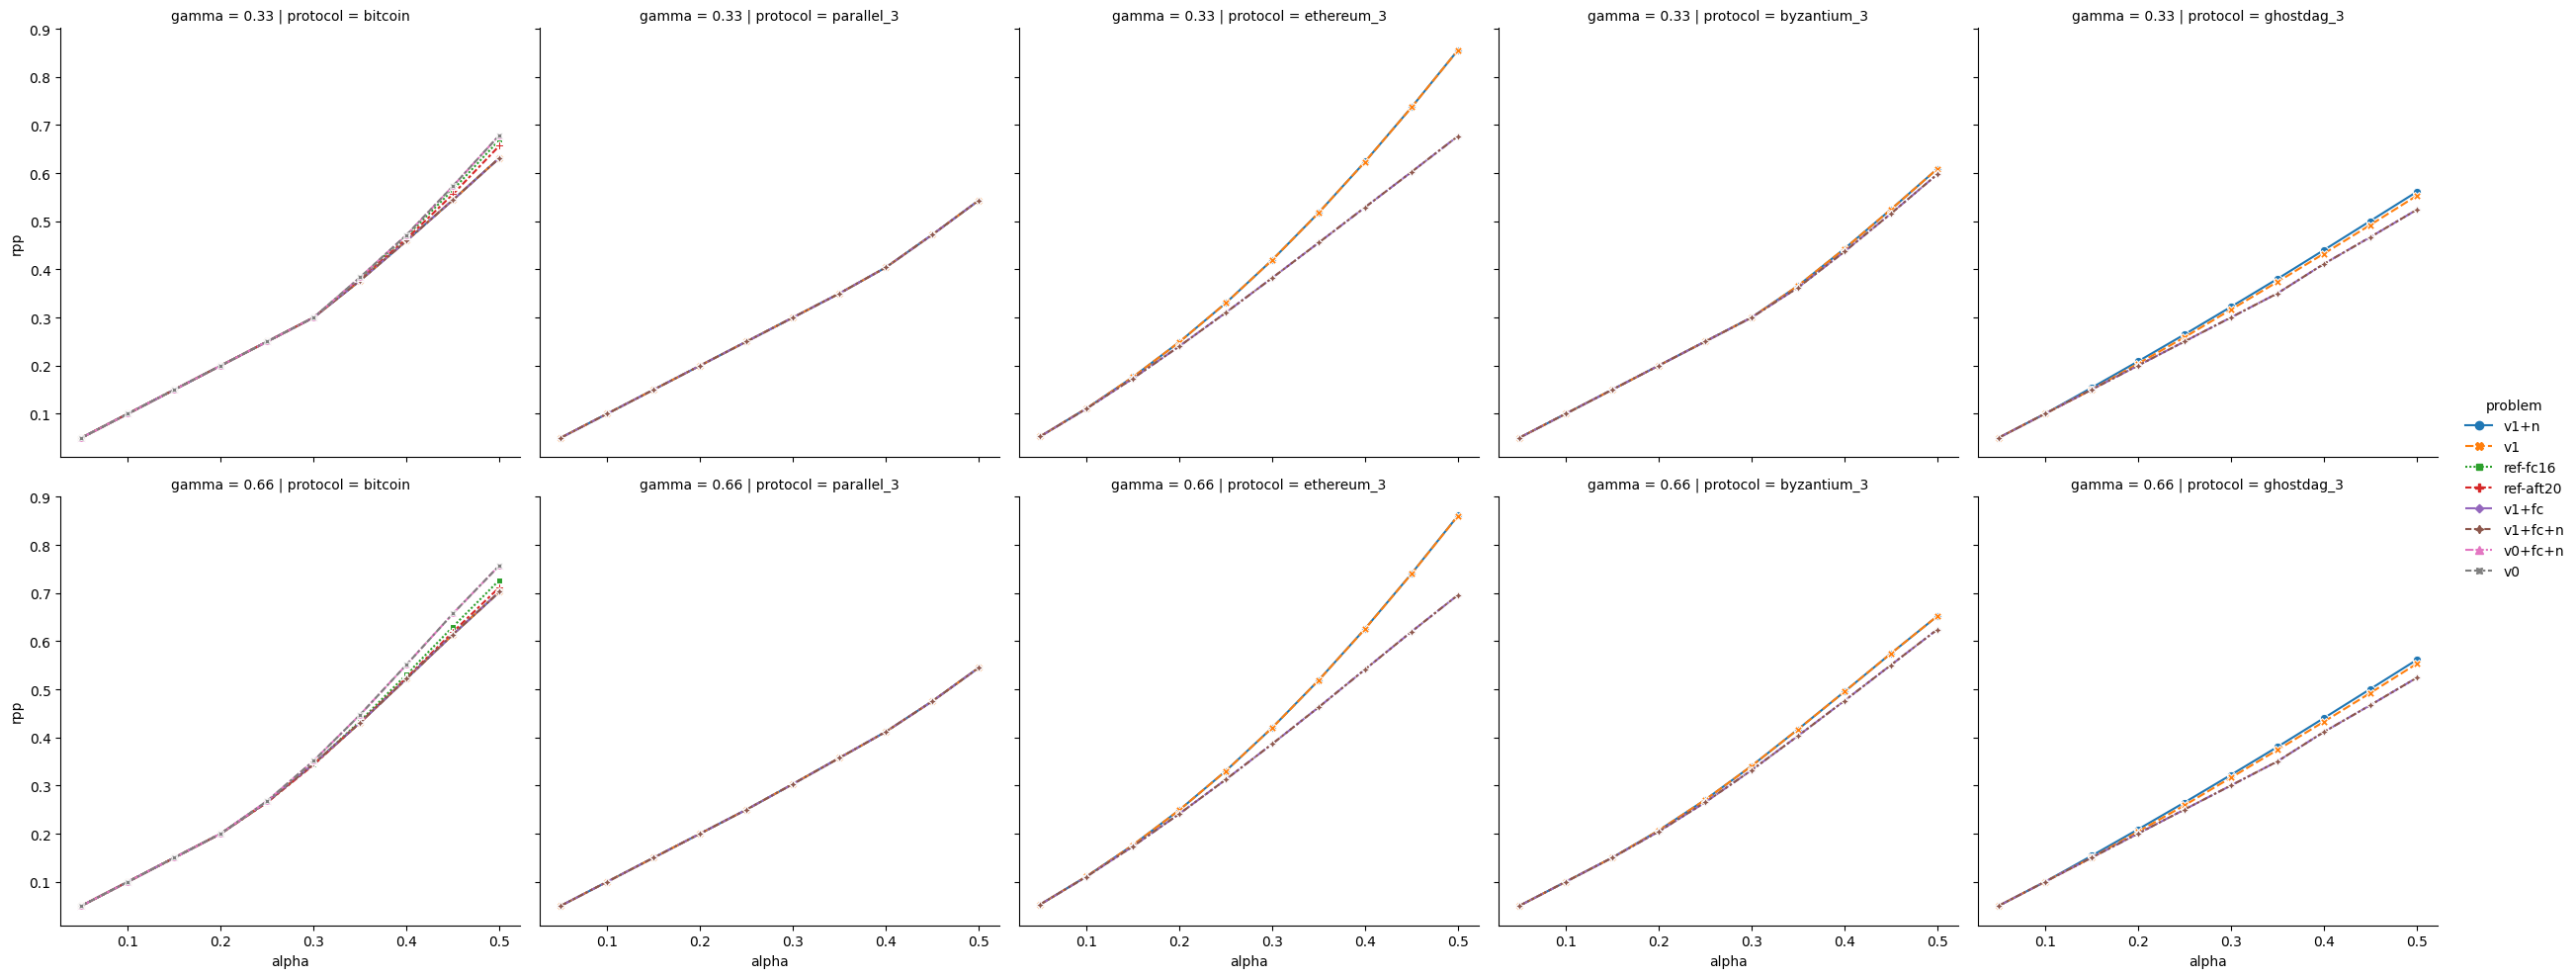

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    col="protocol",
    hue="problem",
    style="problem",
    markers=True,
    row="gamma",
)

# Revenue, PTO model, at source-model steady state

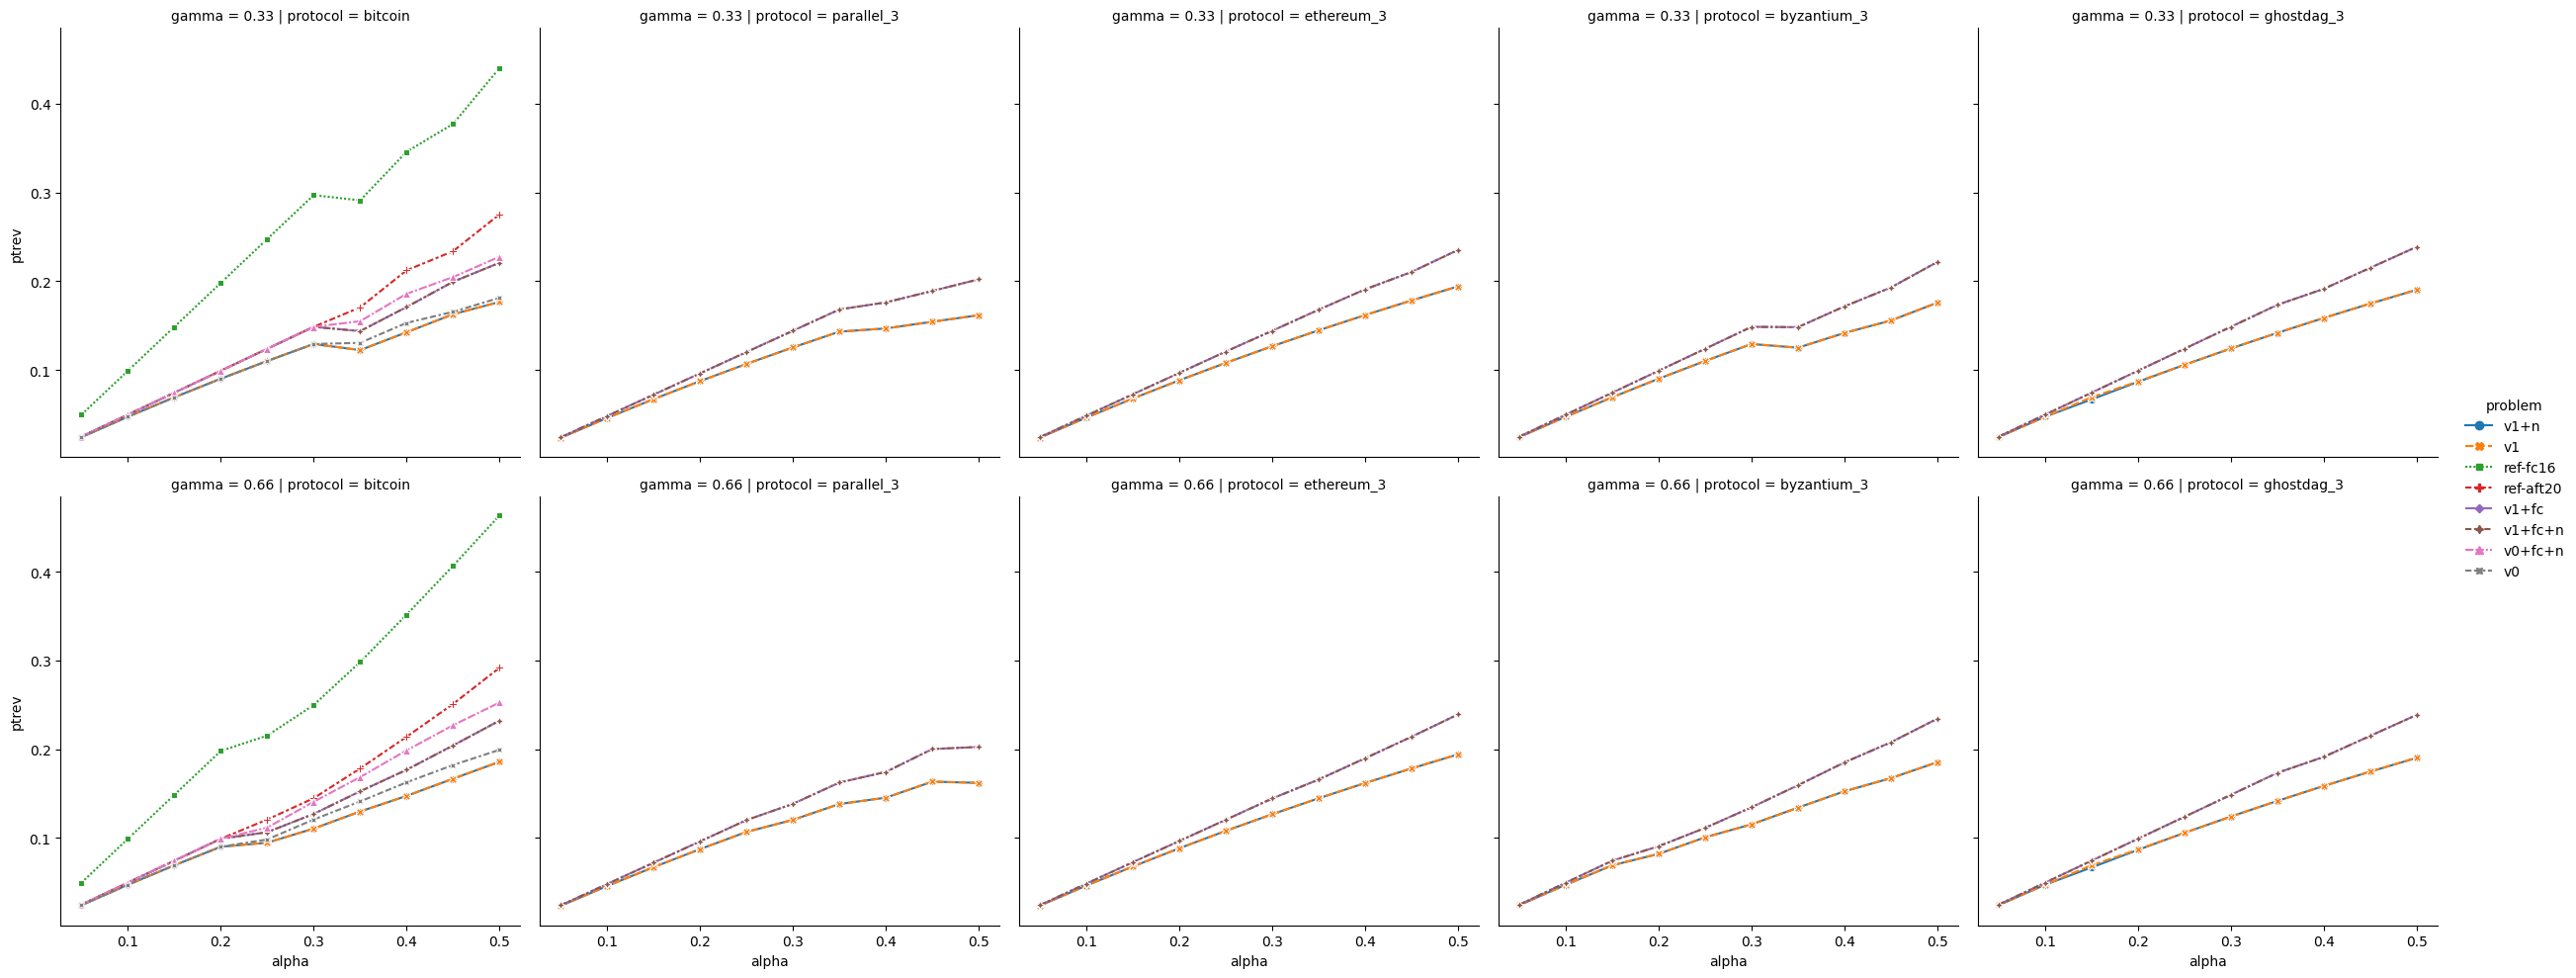

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="ptrev",
    col="protocol",
    hue="problem",
    style="problem",
    markers=True,
    row="gamma",
)